# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 1 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,Directory Traversal,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,NaN,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,Cookie Injection,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,NaN,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,LOG4J,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=WffI9q_8ap3hFmnd4lypIGqEfZyJa6OJ99ehfCfXu...,"Mon, 21 Nov 2022 18:49:38 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
5034,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=col4oXO1qPdIE6cIGwZ902-MPuKDvfqqS_s6Q0DTy...,"Mon, 21 Nov 2022 18:49:38 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,104,200,<h1>Logged in as Jewel</h1><form method='POST'...,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
5035,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=aBSUT4hipf__M_sNTIB9vxXwNSfzjbGyLovCMNFrI...,"Mon, 21 Nov 2022 18:49:40 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,Benign,Benign
5036,127.0.0.1:5000,Moz

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware


In [4]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,0,-0.632456,0,0,0,1,0,0,0,0,-0.786334,0,0.000000,0,-1.0,200,0.000000,-1.000000,-1.0,-1.0,-1.0,Directory Traversal,Malware
1,0,-0.632456,0,0,0,0,0,0,0,0,-0.786146,0,0.000000,4,-1.0,404,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
2,0,-0.800000,0,0,0,0,0,0,0,0,-0.751646,0,1.000000,0,-1.0,200,0.436436,-0.408248,-1.0,-1.0,-1.0,Cookie Injection,Malware
3,0,-0.516398,0,0,0,1,0,0,0,0,-0.716002,0,0.894427,4,-1.0,404,0.577350,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4,0,0.377964,0,0,0,0,0,0,0,37,-0.691095,0,0.000000,4,-1.0,404,0.000000,-1.000000,-1.0,-1.0,-1.0,LOG4J,Malware


In [5]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5038 entries, 0 to 5037
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.Host             5038 non-null   int32  
 1   request.headers.User-Agent       5038 non-null   float64
 2   request.headers.Accept-Encoding  5038 non-null   int32  
 3   request.headers.Accept           5038 non-null   int32  
 4   request.headers.Connection       5038 non-null   int32  
 5   request.headers.Accept-Language  5038 non-null   int32  
 6   request.headers.Sec-Fetch-Site   5038 non-null   int32  
 7   request.headers.Sec-Fetch-Mode   5038 non-null   int32  
 8   request.headers.Sec-Fetch-User   5038 non-null   int32  
 9   request.headers.Sec-Fetch-Dest   5038 non-null   int32  
 10  request.headers.Set-Cookie       5038 non-null   float64
 11  request.method                   5038 non-null   int32  
 12  request.url         

In [6]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'request.headers.Cookie', 'response.headers.Location', 'request.headers.Content-Length', 'response.headers.Set-Cookie']


request.headers.Host                 int32
request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept               int32
request.headers.Connection           int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.status_code                 int64
response.body                      float64
request.headers.Cookie             float64
response.headers.Location          float64
request.headers.Content-Length     float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
dtype: obje

## Train test split

In [7]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(4148, 21) (4148,)
(890, 21) (890,)


Counter({'Malware': 2639, 'Benign': 2399})

## Model choosing and fitting

In [8]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=100)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1975), ('Malware', 2173)]


## Result printout

              precision    recall  f1-score   support

      Benign    0.90682   0.94104   0.92361       424
     Malware    0.94444   0.91202   0.92795       466

    accuracy                        0.92584       890
   macro avg    0.92563   0.92653   0.92578       890
weighted avg    0.92652   0.92584   0.92588       890



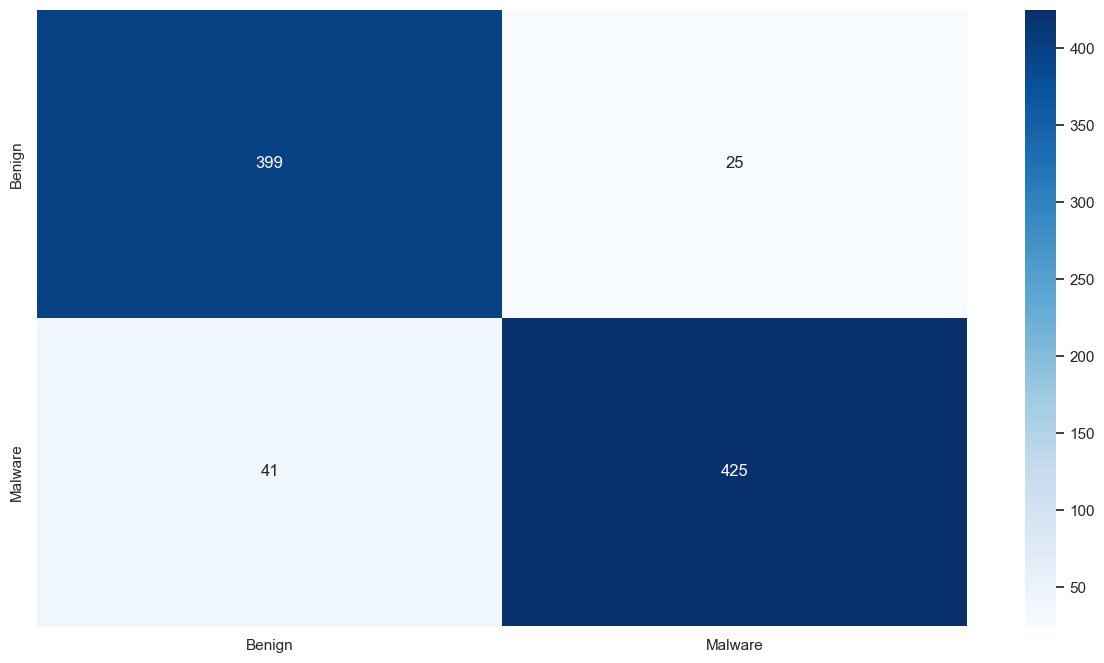

In [9]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [10]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
# with open(f'./dataset_{str(dataset_number)}_val.json') as file:
#     raw_ds = json.load(file)
# test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
# test_df = vectorize_df(test_df)

# Predict with your model
# X = test_df[features_list].to_numpy()
# predictions = clf.predict(X)

# Save your predictions

In [11]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')